In [1]:
import sys
sys.path += ["../"]

In [2]:
import os
import glob
import numpy as np
import uproot
import time
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
import hepaccelerate

In [4]:
import pickle

In [5]:
def midpoints(arr):
    return arr[:-1] + np.diff(arr)/2.0

def plot_hist_step(ax, edges, contents, errors, kwargs_step={}, kwargs_errorbar={}):
    line = histstep(ax, edges, contents, **kwargs_step)
    ax.errorbar(midpoints(edges), contents, errors, lw=0, elinewidth=1, color=line.get_color()[0], **kwargs_errorbar)
    
def histstep(ax, edges, contents, **kwargs):
    ymins = []
    ymaxs = []
    xmins = []
    xmaxs = []
    for istep in range(len(edges)-1):
        xmins += [edges[istep]]
        xmaxs += [edges[istep+1]]
        ymins += [contents[istep]]
        if istep + 1 < len(contents):
            ymaxs += [contents[istep+1]]

    if not "color" in kwargs:
        kwargs["color"] = next(ax._get_lines.prop_cycler)['color']

    ymaxs += [ymaxs[-1]]
    l0 = ax.hlines(ymins, xmins, xmaxs, **kwargs)
    l1 = ax.vlines(xmaxs, ymins, ymaxs, color=l0.get_color(), linestyles=l0.get_linestyle())
    return l0


In [6]:
def plot_hist_ratio(hists_mc, hist_data,
        total_err_stat=None,
        total_err_stat_syst=None,
        figure=None, **kwargs):

    import matplotlib
    matplotlib.use("Agg")
    import matplotlib.pyplot as plt

    xbins = kwargs.get("xbins", None)

    if not figure:
        figure = plt.figure(figsize=(4,4), dpi=100)

    ax1 = plt.axes([0.0, 0.23, 1.0, 0.8])

    hmc_tot = np.zeros_like(hist_data.contents)
    hmc_tot2 = np.zeros_like(hist_data.contents)

    edges = hist_data.edges
    if xbins == "uniform":
        edges = np.arange(len(hist_data.edges))

    for h in hists_mc:
        plot_hist_step(ax1, edges, hmc_tot + h.contents,
            np.sqrt(hmc_tot2 + h.contents_w2),
            kwargs_step={"label": getattr(h, "label", None), "color": getattr(h, "color", None)}
        )

        b = ax1.bar(midpoints(edges), h.contents, np.diff(edges), hmc_tot, edgecolor=getattr(h, "color", None), facecolor=getattr(h, "color", None))
        hmc_tot += h.contents
        hmc_tot2 += h.contents_w2

#    plot_hist_step(h["edges"], hmc_tot, np.sqrt(hmc_tot2), kwargs_step={"color": "gray", "label": None})
    mask_data_from = kwargs.get("mask_data_from_bin", len(hist_data.contents))
    ax1.errorbar(
        midpoints(edges)[:mask_data_from], hist_data.contents[:mask_data_from],
        np.sqrt(hist_data.contents_w2)[:mask_data_from], marker="o", lw=0,
        elinewidth=1.0, color="black", ms=3, label=getattr(hist_data, "label", None))

    if not (total_err_stat_syst is None):
        histstep(ax1, edges, hmc_tot + total_err_stat_syst, color="blue", linewidth=0.5, linestyle="--", label="stat+syst")
        histstep(ax1, edges, hmc_tot - total_err_stat_syst, color="blue", linewidth=0.5, linestyle="--")

    if not (total_err_stat is None):
        histstep(ax1, edges, hmc_tot + total_err_stat, color="gray", linewidth=0.5, linestyle="--", label="stat")
        histstep(ax1, edges, hmc_tot - total_err_stat, color="gray", linewidth=0.5, linestyle="--")

    if kwargs.get("do_log", False):
        ax1.set_yscale("log")
        ax1.set_ylim(1, 100*np.max(hist_data.contents))
    else:
        ax1.set_ylim(0, 2*np.max(hist_data.contents))

    #ax1.get_yticklabels()[-1].remove()

    ax2 = plt.axes([0.0, 0.0, 1.0, 0.16], sharex=ax1)

    ratio = hist_data.contents / hmc_tot
    ratio_err = np.sqrt(hist_data.contents_w2) /hmc_tot
    ratio[np.isnan(ratio)] = 0

    plt.errorbar(midpoints(edges)[:mask_data_from], ratio[:mask_data_from], ratio_err[:mask_data_from], marker="o", lw=0, elinewidth=1, ms=3, color="black")

    if not (total_err_stat_syst is None):
        ratio_up = (hmc_tot + total_err_stat_syst) / hmc_tot
        ratio_down = (hmc_tot - total_err_stat_syst) / hmc_tot
        ratio_down[np.isnan(ratio_down)] = 1
        ratio_down[np.isnan(ratio_up)] = 1
        histstep(ax2, edges, ratio_up, color="blue", linewidth=0.5, linestyle="--")
        histstep(ax2, edges, ratio_down, color="blue", linewidth=0.5, linestyle="--")

    if not (total_err_stat is None):
        ratio_up = (hmc_tot + total_err_stat) / hmc_tot
        ratio_down = (hmc_tot - total_err_stat) / hmc_tot
        ratio_down[np.isnan(ratio_down)] = 1
        ratio_down[np.isnan(ratio_up)] = 1
        histstep(ax2, edges, ratio_up, color="gray", linewidth=0.5, linestyle="--")
        histstep(ax2, edges, ratio_down, color="gray", linewidth=0.5, linestyle="--")


    plt.ylim(0.5, 1.5)
    plt.axhline(1.0, color="black")

    if xbins == "uniform":
        print(hist_data.edges)
        ax1.set_xticks(edges)
        ax1.set_xticklabels(["{0:.2f}".format(x) for x in hist_data.edges])

    ax1.set_xlim(min(edges), max(edges))
    xlim = kwargs.get("xlim", None)
    if not xlim is None:
        ax1.set_xlim(*xlim)

    ylim = kwargs.get("ylim", None)
    if not ylim is None:
        ax1.set_ylim(*ylim)

    return ax1, ax2

In [8]:
with open("../data/cuda0_nt2_nj12_njec20_full.pkl", "rb") as fi:
    results = pickle.load(fi)
hists = results["hists"]

In [139]:
hists["SingleMu"]

{'hist__nmu1_njet4_nbjet1__j1_eta': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4c056550>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a4c056128>},
 'hist__nmu1_njet4_nbjet1__mu1_pt': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4c056da0>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a4c0569e8>},
 'hist__nmu1_njet4_nbjet1__j1_btag': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4c056f60>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a4c056278>},
 'hist__nmu1_njet4_nbjet1__el1_phi': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4c056240>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a4c056c18>},
 'hist__nmu1_njet4_nbjet1__mu2_iso': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4c056080>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a4b66bc50>},
 'hist__nmu1_njet4_nbjet1__el2_phi': {'jec1__down': <hepaccelerate.utils.Histogram at 0x7f2a4b66b940>,
  'jec1__up': <hepaccelerate.utils.Histogram at 0x7f2a

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


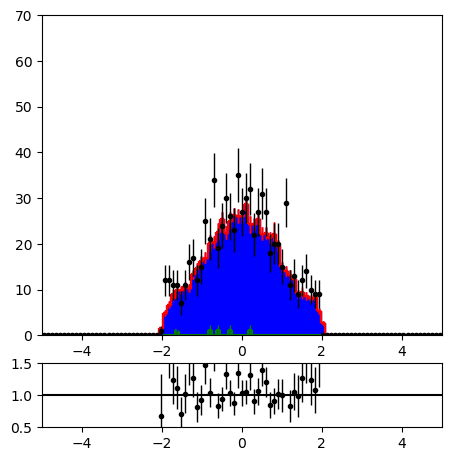

In [158]:
histname = "hist__nmu1_njet4_nbjet1__j1_eta"
skey = "jec1__up"
mc_samps = [
    'DYJetsToLL', 'TTJets_FullLeptMGDecays', 'TTJets_Hadronic', 'TTJets_SemiLeptMGDecays',
    'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu'
]
colors = {
    "DYJetsToLL": "green",
    "TTJets_FullLeptMGDecays": "blue",
    "TTJets_Hadronic": "blue",
    "TTJets_SemiLeptMGDecays": "blue",
    "W1JetsToLNu": "red",
    "W2JetsToLNu": "red",
    "W3JetsToLNu": "red",
}

#in inverse pb
lumi = 10000.0

#in picobarns
#from https://escholarship.org/content/qt0gt3c4cr/qt0gt3c4cr.pdf?t=o4y9h9&nosplash=7aa805932d08bd7f9078f6a6e6034fc6
cross_sections = {
    "TTJets_SemiLeptMGDecays": 102.50,
    "TTJets_Hadronic": 106.93,
    "TTJets_FullLeptMGDecays": 24.56,
    "DYJetsToLL": 3532.8,
    "W1JetsToLNu": 6663,
    "W2JetsToLNu": 2159,
    "W3JetsToLNu": 640,
}

hmc = {s: hists[s][histname][skey] for s in mc_samps}
hd = hists["SingleMu"][histname][skey]

for s in mc_samps:
    hmc[s] *= lumi *cross_sections[s] * (1.0/results["numevents"][s])
    hmc[s].label = s
    hmc[s].color = colors[s]
    
ax1, ax2 = plot_hist_ratio([hmc[s] for s in mc_samps], hd)
#ax1.legend()
#ax1.set_yscale("log")
#ax1.set_ylim(0, 1000)